# Make Environment

## ONNX and Open Vino

In [ ]:
!pip install openvino openvino-dev pillow
!pip install onnx onnxruntime
!pip install numpy matplotlib

In [ ]:
import os
from PIL import Image
from typing import List, Tuple, Dict
import numpy as np
import torch
import torchvision
import onnxruntime as rt
from openvino.tools import mo
from openvino.runtime import serialize, Model, Core
from typing import Iterable

In [ ]:
def flatten(items):
    """Yield items from any nested iterable"""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            for sub_x in flatten(x):
                yield sub_x
        else:
            yield x

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
onnx_path = "/content/gdrive/MyDrive/AI/yolov3.onnx"
reference_path = "/content/gdrive/MyDrive/AI/yolov3.npz"
input_path = "/content/gdrive/MyDrive/AI/yolov3_input.npz"

In [ ]:
def check_paths(path: str, inst: str) -> None:
  assert os.path.exists(path), f"{inst} is not available by path {path}"

In [ ]:
check_paths(onnx_path, "Onnx Model")
check_paths(reference_path, "Reference data")
check_paths(input_path, "Input_data")

##Baseline
https://pjreddie.com/darknet/yolo/


In [ ]:
!git clone https://github.com/pjreddie/darknet
%cd darknet
!wget https://pjreddie.com/media/files/yolov3.weights
!make

In [ ]:
from ctypes import *
import math
import random

def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

def c_array(ctype, values):
    arr = (ctype*len(values))()
    arr[:] = values
    return arr

class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int)]


class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]

lib = CDLL("/content/darknet/libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

predict = lib.network_predict
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

set_gpu = lib.cuda_set_device
set_gpu.argtypes = [c_int]

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int)]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

network_predict = lib.network_predict
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

def classify(net, meta, im):
    out = predict_image(net, im)
    res = []
    for i in range(meta.classes):
        res.append((meta.names[i], out[i]))
    res = sorted(res, key=lambda x: -x[1])
    return res

def detect(net, meta, image, thresh=.5, hier_thresh=.5, nms=.45):
    im = load_image(image, 0, 0)
    num = c_int(0)
    pnum = pointer(num)
    predict_image(net, im)
    dets = get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum)
    num = pnum[0]
    if (nms): do_nms_obj(dets, num, meta.classes, nms);

    res = []
    for j in range(num):
        for i in range(meta.classes):
            if dets[j].prob[i] > 0:
                b = dets[j].bbox
                res.append((meta.names[i], dets[j].prob[i], (b.x, b.y, b.w, b.h)))
    res = sorted(res, key=lambda x: -x[1])
    free_image(im)
    free_detections(dets, num)
    return res

## Preprocess Input data 

1. Rename input name from 'data' to 'input_1'
2. Rescale input_1 to 416, 416
3. Normalize by factor 255
3. Permute order of input_1 to 2,0,1
4. Expand dims by 1
5. Recast both layers to float32 


In [ ]:
def letterbox_image(image: Image, size: tuple):
    """resize image with unchanged aspect ratio using padding"""
    iw, ih = image.size
    w, h = size
    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)

    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))

    return new_image

def preprocess(h, w, key0, key1):
    def _preprocess(data):
        model_image_size = (h, w)
        img = Image.fromarray(data[key0], 'RGB')
        boxed_image = letterbox_image(img, tuple(reversed(model_image_size)))
        image_data = np.array(boxed_image, dtype='float32')
        data[key0] = image_data
        data[key1] = np.array([image_data.shape[:2]])
        return data

    return _preprocess

In [ ]:
input_data = np.load(input_path, allow_pickle=True)
input_data = dict(input_data)
input_data['input_1'] = input_data.pop('data') # 1

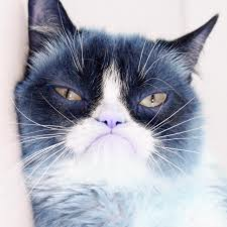

In [ ]:
image = Image.fromarray(np.uint8(input_data['input_1'])).convert('RGB')
image.save("cat.png")
image

In [ ]:
input_data = preprocess(416, 416, 'input_1', 'image_shape')(input_data) # 2
image_array = input_data['input_1']
input_data['input_1'] = input_data['input_1']/255 # 3
input_data['input_1'] = input_data['input_1'].transpose(2,0,1) #4
input_data['input_1'] = np.expand_dims(input_data['input_1'], 0) # 5
input_data['input_1'] = input_data['input_1'].astype('float32') # 6
input_data['image_shape'] = input_data['image_shape'].astype('float32') 

In [ ]:
print(f"Cat input shape: {input_data['input_1'].shape}") 

Cat input shape: (1, 3, 416, 416)


# Model Inferring and postprocessing
Sources: 

https://github.com/onnx/models/tree/master/vision/object_detection_segmentation/yolov3

https://github.com/WongKinYiu/yolov7/tree/main/utils

The model has 3 outputs. 
1. boxes: (1x'n_candidates'x4), the coordinates of all anchor boxes, 
1. scores: (1x80x'n_candidates'), the scores of all anchor boxes per class, 
1. indices: ('nbox'x3), selected indices from the boxes tensor. 

The selected index format is (batch_index, class_index, box_index). The class list is [here](https://github.com/qqwweee/keras-yolo3/blob/master/model_data/coco_classes.txt)




In [ ]:
ODC_KEYS = ['class', 'prob', 'xmin', 'ymin', 'xmax', 'ymax']

CLASSES = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train",
            "truck", "boat", "traffic light", "fire hydrant", "stop sign",
           "parking meter", "bench", "bird", "cat", "dog", "horse",
           "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
           "backpack", "umbrella", "handbag", "tie", "suitcase",
           "frisbee", "skis", "snowboard", "sports ball", "kite"
           "baseball bat", "baseball glove","skateboard", "surfboard", 
           "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", 
           "spoon", "bowl", "banana", "apple", "sandwich", "orange", 
           "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", 
           "chair", "sofa", "pottedplant", "bed", "diningtable", 
           "toilet", "tvmonitor", "laptop", "mouse", "remote", 
           "keyboard", "cell phone", "microwave", "oven", "toaster", 
           "sink", "refrigerator", "book", "clock", "vase", "scissors", 
           "teddy bear", "hair drier", "toothbrush"]

COLORS = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(CLASSES)}

def infer(model_path, input_dict):
  ret = {}
  sess = rt.InferenceSession(model_path)

  for i in range(0, len(sess.get_outputs())):
    output_name = sess.get_outputs()[i].name
    ret[output_name] = np.array(sess.run([output_name], input_dict)[0])
  return ret

def postproc(model_output:dict) -> dict:
  boxes, scores, indices = model_output['yolonms_layer_1/ExpandDims_1:0'], model_output['yolonms_layer_1/ExpandDims_3:0'], model_output['yolonms_layer_1/concat_2:0']
  detections, out_boxes, out_scores, out_classes = [], [], [], []
  for idx_ in indices:
      out_classes.append(idx_[1])
      out_scores.append(scores[tuple(idx_)])
      idx_1 = (idx_[0], idx_[2])
      out_boxes.append(boxes[idx_1])

  num_detections = len(out_classes)
  for i in range(num_detections):
    obj = [out_classes[i], out_scores[i], *out_boxes[i]]
    obj = dict(zip(ODC_KEYS, obj))
    detections.append(obj)

  return {'detections': np.array(detections)}

## Convert ONNX Model to OpenVINO Intermediate Representation (IR)

In [ ]:
ov_model = mo.convert_model(onnx_path)
serialize(ov_model, 'yolov3.xml')
ov_model_ir = 'yolov3.xml'

## Infer ONNX

In [ ]:
out = infer(onnx_path, input_data)
infer_onnx = postproc(out)

## Infer Baseline

In [ ]:
net = load_net(b"./cfg/yolov3.cfg", b"./yolov3.weights", 0)
meta = load_meta(b"./cfg/coco.data")
infer_baseline = detect(net, meta, b"./cat.png")[0]

In [ ]:
infer_baseline = list(flatten(infer_baseline))
infer_baseline = {'detections':dict(zip(ODC_KEYS, infer_baseline))}

## Infer OpenVino

In [ ]:
ie = Core()
ov = ie.read_model(ov_model_ir)
compiled_model = ie.compile_model(ov, "CPU")
infer_ov = compiled_model(input_data)

In [ ]:
keys = ['yolonms_layer_1/ExpandDims_1:0', 'yolonms_layer_1/ExpandDims_3:0', 'yolonms_layer_1/concat_2:0']
infer_ov = dict(zip(keys, [v for v in infer_ov.values()])) 

In [ ]:
infer_ov = postproc(infer_ov)

{'detections': array([{'class': 15, 'prob': 0.9975917, 'xmin': 21.523602, 'ymin': 26.393246, 'xmax': 396.04517, 'ymax': 386.87122}],
       dtype=object)}

# Counting Jaccard similarity metric between two inferring results
https://en.wikipedia.org/wiki/Jaccard_index

In [ ]:
def jaccard(set0:dict, set1:dict)->float:
    """
    :param set0: dict with coordinates of one bound box from first inference
    :param set1: dict with coordinates of one bound box from second inference
    :return: float value of Jaccard metric for them
    """
    if (set0['xmax'] < set1['xmin']) or (
            set1['xmax'] < set0['xmin']) or (
            set1['ymax'] < set0['ymin']) or (
            set0['ymax'] < set1['ymin']):
        iou = 0
    else:
        intsect = {}
        intsect['xmin'] = max(set0['xmin'], set1['xmin'])
        intsect['xmax'] = min(set0['xmax'], set1['xmax'])
        intsect['ymin'] = max(set0['ymin'], set1['ymin'])
        intsect['ymax'] = min(set0['ymax'], set1['ymax'])
		delta_x_is = intsect['xmax'] - intsect['xmin']
		delta_y_is = intsect['ymax'] - intsect['ymin']
        intersection_square = delta_x_is * delta_y_is
		
		delta_x_us0 = set0['xmax'] - set0['xmin']
		delta_y_us0 = set0['ymax'] - set0['ymin']
		delta_x_us1 = set1['xmax'] - set1['xmin']
		delta_y_us1 = set1['ymax'] - set1['ymin']
        union_square = delta_x_us0 * delta_y_us0 + delta_x_us1 * delta_y_us1 - intersection_square
		
        if union_square == 0:
            iou = 1
        else:
            iou = intersection_square / union_square
    return iou if not np.isnan(iou) else 0

## ONNX aganist Baseline

In [ ]:
IOB = jaccard(infer_onnx['detections'][0], infer_baseline['detections'])
print(f"ONNX aganist Baseline {IOB}")

ONNX aganist Baseline 0.09660533962473347


## ONNX against OV

In [ ]:
IOB = jaccard(infer_onnx['detections'][0], infer_ov['detections'][0])
print(f"ONNX aganist Baseline {IOB}")

ONNX aganist Baseline 0.9999997615814209


## OV against Baseline

In [ ]:
IOB = jaccard(infer_baseline['detections'], infer_ov['detections'][0])
print(f"OV aganist Baseline {IOB}")

OV aganist Baseline 0.09660531726350957


In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
!/content/darknet/darknet detect /content/darknet/cfg/yolov3.cfg /content/darknet/yolov3.weights /content/darknet/cat.png

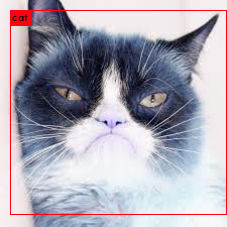

In [ ]:
Image.open("predictions.jpg")

## Draw boxes

Got draw box func from YOLOv7 utils

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1157 (delta 10), reused 15 (delta 8), pack-reused 1139
Receiving objects: 100% (1157/1157), 70.42 MiB | 18.84 MiB/s, done.
Resolving deltas: 100% (498/498), done.


In [ ]:
%cd yolov7

/content/darknet/yolov7


In [ ]:
from utils.plots import plot_one_box
#from utils.general import non_max_suppression

In [ ]:
def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords

def clip_coords(boxes, img_shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0].clip(0, img_shape[1])  # x1
    boxes[:, 1].clip(0, img_shape[0])  # y1
    boxes[:, 2].clip(0, img_shape[1])  # x2
    boxes[:, 3].clip(0, img_shape[0])  # y2

def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        print("No predictions!")
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        
        label = f'{names[int(cls)]} {conf:.2f}'
        print(f"Coords:{xyxy} label: {label}")
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

In [ ]:
arr = [i for i in infer_onnx['detections'][0].values()]
pred = np.array([arr[2:] + list(reversed(arr[:2]))]).astype('float32')
pred.shape

(1, 6)

In [ ]:
draw_box_onnx = draw_boxes(pred, (1,3,416,416), np.array(Image.open("/content/darknet/predictions.jpg")), CLASSES, COLORS)

Coords:[12.0, 14.0, 216.0, 211.0] label: cat 1.00


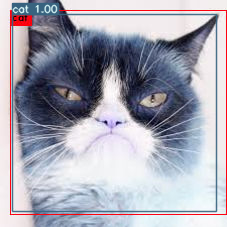

In [ ]:
Image.fromarray(np.uint8(draw_box_onnx)).convert('RGB')